In [1]:
#if needed, go for it
#!pip install pandas
#!pip install geopy
#!pip install sklearn
#!conda install cartopy
#!conda install -c conda-forge xarray dask netCDF4 bottleneck

In [2]:
from scipy.io import loadmat
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import os
from matplotlib.lines import Line2D


In [3]:
def ordinal_to_dt(time):
    day = time%1 * 24
    hour = day%1 * 60
    seconds = hour%1 *60
    
    return dt.datetime.strptime(f"{int(day)}:{int(hour)}:{int(seconds)}", '%H:%M:%S') 

ordinal_to_dt = np.vectorize(ordinal_to_dt)

In [4]:
def compute_velocities(df):
    #We compute the geodesic distance using geopy function, for all the values of this drifter
    #The new column we are creating its going to be filled with the array defined in the for loop
    df['distance'] = [ 
        #compute the distance
        geodesic(
            [df.loc[i-1,'Latitude'],df.loc[i-1,'Longitude']], #pos i-1
            [df.loc[i,'Latitude'],df.loc[i,'Longitude']] #pos i
        ).m
        if i>0 #not for the first element to avoid errors
        else np.finfo(float).eps #instead we fill it with an infinitesimal value to avoid dividing by 0
        for i in range(len(df)) #for i position such as i is the number of elements
    ]
    #compute the time delta
    df['time_delta'] = [ 
        #by resting time(i-1) and time(i) and gettings the seconds of it
        np.abs((df.loc[i-1,'DeviceDateTime']-df.loc[i,'DeviceDateTime']).total_seconds())
        if i>0
        else 1
        for i in range(len(df))
    ]
    #The velocity will be de  division of this values
    df['velocity'] = df['distance']/df['time_delta']

    # apply normalization techniques for velocity visualization
    df['vel_normalized'] = MinMaxScaler().fit_transform(np.array(df['velocity']).reshape(-1,1))

    return df

### Load the drifter data from 2021

In [5]:
#dictionary with the julian dates
drifter_2021_dir = './Drifter-2021'
#if the filename contains 'logsheet' for every file in the folder
logsheets_files = [i for i in os.listdir(drifter_2021_dir) if 'logsheet_MIR' in i]
#for each day
#dictonary to store the data per day
data_2021 = {}
for logsheet_file in sorted(logsheets_files):
    #We split the file by '.' and then by '_' to get the date '14102021' from 'logsheet_MIR_14102021.csv'
    day = logsheet_file.split('.')[0].split('_')[-1]
    #format it to python datetime
    day_datetime = dt.datetime.strptime(day, '%d%m%Y') 
    #I realised that the julian dates given in the model are for oct 2022 not 2021, so we need to sum a year
    julian_day = (day_datetime + dt.timedelta(days=366)).toordinal()
    print(f"Processing {day_datetime} data...")
   
    #Read the log sheet and clean the id to get only 3 digits identifier, then wew use it as an index
    logsheet = pd.read_csv(f'{drifter_2021_dir}/{logsheet_file}',delimiter=";")
    logsheet['Flotteur_ID'] = logsheet['Flotteur_ID'].apply(lambda x: str(x)[-3:])
    logsheet = logsheet.set_index('Flotteur_ID')
    
    #list the .nc files for the the day
    drifters_files = [i  for i in os.listdir('./Drifter-2021') if day in i and 'nc' in i]
    #print(drifters_files)
    #dictonary to store the drifter data
    drifters= {}
    for drifter_file in drifters_files:
    
        #get id (only last 3 digits) ('390' from '14102021_00390.nc')
        drifter_id = drifter_file.split(".")[0].split("_")[-1][-3:]
        #open nc with xarray
        xr_df = xr.open_dataset(f'./Drifter-2021/{drifter_file}')
        #now lets convert it to pandas
        df = xr_df.to_dataframe()

        #new column to identify our friend
        df['DeviceName'] = drifter_id
        #create a new col with datetime from ordinal time (only hours)
        df['DeviceDateTime'] = ordinal_to_dt(df['TIME'].to_numpy())
        
        #convert ordinal time from 1950 to Julian date
        df['Julian_date'] = df['TIME']%1+julian_day #Julian day + decimals of the ordinal 1950 day
        
        #rename to follow the same naming
        df = df.rename(
            columns={
                "LATITUDE" : "Latitude",
                "LONGITUDE" : "Longitude"
            }
        )
        #forget what needs to be forgotten
        df = df.drop(columns=['DROGUE_DEPTH','BUOY_ID','STATIONNAME'])
        #Sort the DataFrame by the time and reset the index
        df = df.sort_values(by='DeviceDateTime').reset_index()
        #Compute velocities
        df = compute_velocities(df)
        #Save it in the dictionary using the id as key
        drifters[drifter_id] = df
    
    
    # In here we take the first element of each drifter and we build a drifter deployment dataset
    #containing the deployment lat,lon,time and depth
    
    first_elements = [df.loc[0] for key,df in drifters.items()]
    deployments = pd.concat(first_elements, axis=1).transpose().set_index('DeviceName')
    deployments = deployments.drop(columns=["distance","time_delta","velocity","vel_normalized","r","c"])  
    deployments['depth'] =logsheet.loc[deployments.index,'Drogue_depth']
    deployments = deployments.sort_values(by='Julian_date')
    
    #save our precious data
    data_2021[day] = {
        'deployments': deployments,
        'drifters': drifters
    }

Processing 2021-10-12 00:00:00 data...
Processing 2021-10-13 00:00:00 data...
Processing 2021-10-14 00:00:00 data...


In [6]:
#Load our model data
model = loadmat('./model_data/Tbay_current_Wind_data.mat')
#Get the velocity field components for depth=0
u = np.moveaxis(model['U_current'][:,:,:,:],-1,0)
v = np.moveaxis(model['V_current'][:,:,:,:],-1,0)
norm = np.sqrt(v**2+u**2)
u_wind = np.moveaxis(model['U_Wind'],-1,0)
v_wind = np.moveaxis(model['V_Wind'],-1,0)
norm_wind = np.sqrt(v_wind**2+u_wind**2)

#create a xarray dataset (efficient for spatio-temporal grids)
xrds = xr.Dataset(
    coords = dict(
        lon = model['xx'][:,0],
        lat = model['yy'][0,:],
        time = model['time'][0],
        depth = [0,.6,1]
    ),
    data_vars = dict(
        u = ( ['time', 'lon', 'lat','depth'], u),
        v =  ( ['time', 'lon', 'lat','depth'], v),
        norm = ( ['time', 'lon', 'lat','depth'], norm),
        u_wind = ( ['time', 'lon', 'lat'], u_wind),
        v_wind = ( ['time', 'lon', 'lat'], v_wind),
        norm_wind = ( ['time', 'lon', 'lat'], norm_wind),
    )
)

In [13]:
xrds

<xarray.Dataset>
Dimensions:    (time: 72, lon: 200, lat: 100, depth: 3)
Coordinates:
  * lon        (lon) float64 5.884 5.886 5.887 5.888 ... 6.129 6.131 6.132 6.133
  * lat        (lat) float64 43.04 43.04 43.04 43.04 ... 43.13 43.13 43.13 43.13
  * time       (time) float64 7.384e+05 7.384e+05 ... 7.384e+05 7.384e+05
  * depth      (depth) float64 0.0 0.6 1.0
Data variables:
    u          (time, lon, lat, depth) float32 -0.1334 -0.1334 ... 0.0 0.0
    v          (time, lon, lat, depth) float32 -0.01633 -0.01633 ... 0.0 0.0
    norm       (time, lon, lat, depth) float32 0.1344 0.1344 0.1352 ... 0.0 0.0
    u_wind     (time, lon, lat) float32 1.907 1.906 1.906 1.905 ... 0.0 0.0 0.0
    v_wind     (time, lon, lat) float32 0.2135 0.2072 0.2008 ... 0.0 0.0 0.0
    norm_wind  (time, lon, lat) float32 1.919 1.918 1.916 1.915 ... 0.0 0.0 0.0

In [7]:
def advect_particle_euler(particle,runtime,dt):
    """
    Advection of particles using Explicit Euler (aka Euler Forward) integration.
    params:
        particle: dict
            dict containing the particle initial conditions
        runtime: int
            time to run the model in sec onds
        dt: float
            differential of time to solve the ecuations
    returns:
        _: dict
            dict containing the id and trajectory (lon,lat) of the particle
    """
    
    t = particle['time']
    depth = particle['depth']
    lon_t = particle['lon']
    lat_t = particle['lat']
    all_lats = []
    all_lons = []
    endtime = t + runtime/(3600*24)
    while t < endtime:  
        #print(lon_t,lat_t)
        all_lons.append(lon_t)
        all_lats.append(lat_t)
        #velocities in meters per seconds
        v_t_ms = xrds['v'].interp({"time":t,"lon":lon_t,"lat":lat_t,"depth":depth}).data
        u_t_ms = xrds['u'].interp({"time":t,"lon":lon_t,"lat":lat_t,"depth":depth}).data
        #velocities in degrees per seconds
        v_t_ds = v_t_ms * (1/1000) * (1/110.574)
        u_t_ds = u_t_ms * (1/1000) * (1/(111.320*np.cos(v_t_ds*np.pi/180)))
        #Euler method
        lon_t = lon_t + dt*u_t_ds
        lat_t = lat_t + dt*v_t_ds
        t += dt/(3600*24)    
    
    return {
        'id':particle['id'],
        'lons':all_lons,
        'lats':all_lats
    }


def advect_particle_RK4(particle,runtime,dt):
    """
    Advection of particles using fourth-order Runge-Kutta integration.
    params:
        particle: dict
            dict containing the particle initial conditions
        runtime: int
            time to run the model in sec onds
        dt: float
            differential of time to solve the ecuations
    returns:
        _: dict
            dict containing the id and trajectory (lon,lat) of the particle
    """
    
    t = particle['time']
    depth = particle['depth']
    lon_t = particle['lon']
    lat_t = particle['lat']
    all_lats = []
    all_lons = []
    endtime = t + runtime/(3600*24)
    while t < endtime:  
        #print(lon_t,lat_t)
        #velocities in meters per seconds
        all_lons.append(lon_t)
        all_lats.append(lat_t)
        #sel methods in xr dataset is able to select from any time,lat,lon 
        v_t_ms = xrds['v'].sel({"time":t,"lon":lon_t,"lat":lat_t,"depth":depth},method='nearest').data
        u_t_ms = xrds['u'].sel({"time":t,"lon":lon_t,"lat":lat_t,"depth":depth},method='nearest').data
        #velocities in degrees per seconds
        v1 = v_t_ms * (1/1000) * (1/110.574)
        u1 = u_t_ms * (1/1000) * (1/(111.320*np.cos(v1*np.pi/180)))
        #RK-4 method
        #1
        lon1 = lon_t + dt*u1*.5
        lat1 = lat_t + dt*v1*.5
        #2
        v_t_ms = xrds['v'].sel({"time":t+.5*dt,"lon":lon1,"lat":lat1,"depth":depth},method='nearest').data
        u_t_ms = xrds['u'].sel({"time":t+.5*dt,"lon":lon1,"lat":lat1,"depth":depth},method='nearest').data
        v2 = v_t_ms * (1/1000) * (1/110.574)
        u2 = u_t_ms * (1/1000) * (1/(111.320*np.cos(v2*np.pi/180)))
        lon2 = lon_t + dt*u2*.5
        lat2 = lat_t + dt*v2*.5
        #3
        v_t_ms = xrds['v'].sel({"time":t+.5*dt,"lon":lon2,"lat":lat2,"depth":depth},method='nearest').data
        u_t_ms = xrds['u'].sel({"time":t+.5*dt,"lon":lon2,"lat":lat2,"depth":depth},method='nearest').data
        v3 = v_t_ms * (1/1000) * (1/110.574)
        u3 = u_t_ms * (1/1000) * (1/(111.320*np.cos(v3*np.pi/180)))
        lon3 = lon_t + dt*u3
        lat3 = lat_t + dt*v3
        #4
        v_t_ms = xrds['v'].sel({"time":t+dt,"lon":lon3,"lat":lat3,"depth":depth},method='nearest').data
        u_t_ms = xrds['u'].sel({"time":t+dt,"lon":lon3,"lat":lat3,"depth":depth},method='nearest').data
        v4 = v_t_ms * (1/1000) * (1/110.574)
        u4 = u_t_ms * (1/1000) * (1/(111.320*np.cos(v4*np.pi/180)))
        #final phase
        lon_t += (u1 + 2*u2 + 2*u3 + u4) / 6. * dt
        lat_t += (v1 + 2*v2 + 2*v3 + v4) / 6. * dt
    
        t += dt/(3600*24)  
    
    return {
        'id':particle['id'],
        'lons':all_lons,
        'lats':all_lats
    }

In [8]:
#Visualization function
def plot_model_trajectories(adv_euler_data, adv_RK4_data, real_data, figsize=(10,8.5)):
    stamen_terrain = cimgt.Stamen('terrain-background')
    f = plt.figure(figsize=figsize)

    ax = f.add_subplot(projection=stamen_terrain.crs)
    ax.add_image(stamen_terrain, 13)
    ax.set_extent([5.9, 6.05, 43.045, 43.12], crs=ccrs.Geodetic())

    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False


    for _,drifter in real_data.items():
        ax.scatter(drifter['Longitude'].tolist(),drifter['Latitude'].tolist(),marker='.', c='red', alpha=.5, transform=ccrs.PlateCarree())

    for particle in adv_RK4_data:   
        ax.scatter(particle['lons'],particle['lats'],marker='.', c='orange', alpha=.8, transform=ccrs.PlateCarree())

    for particle in adv_euler_data:

        ax.scatter(particle['lons'],particle['lats'],marker='.', c='blue', alpha=.8, transform=ccrs.PlateCarree())
        ax.scatter(particle['lons'][0],particle['lats'][0],marker='x', c='grey', alpha=1, transform=ccrs.PlateCarree())
        ax.text(particle['lons'][0],particle['lats'][0],particle['id'],transform=ccrs.Geodetic())


    custom_lines = [
        Line2D([0], [0],marker='o', color='blue', lw=0, markersize=4),
        Line2D([0], [0],marker='o', color='orange', lw=0, markersize=4),
        Line2D([0], [0],marker='o', color='red', lw=0, markersize=4)
    ]           
    ax.legend(custom_lines,['Euler advection','RK4 advection', 'Drifter Trajectories'])
    
    return ax

In [9]:
advection_results = {}
for key,data_day in data_2021.items():
    particles = [
        {
            'id':index,
            'lon':row['Longitude'],
            'lat':row['Latitude'],
            'depth':row['depth'],
            'time':row['Julian_date']
        }
        for index, row in data_day['deployments'].iterrows()
    ]
    
    print("Computing for ",key,"...")
    adv_euler_data = [advect_particle_euler(p,3600*3,1200) for p in particles]
    adv_RK4_data = [advect_particle_RK4(p,3600*3,1200) for p in particles]
    
    advection_results[key] = {
        'euler': adv_euler_data,
        'RK4': adv_RK4_data,
        'real': data_day['drifters']
    }

Computing for  12102021 ...
Computing for  13102021 ...
Computing for  14102021 ...


/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:564: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:564: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:564: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.

/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:564: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:564: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.py:564: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/home/frop/miniconda3/lib/python3.9/site-packages/xarray/core/missing.

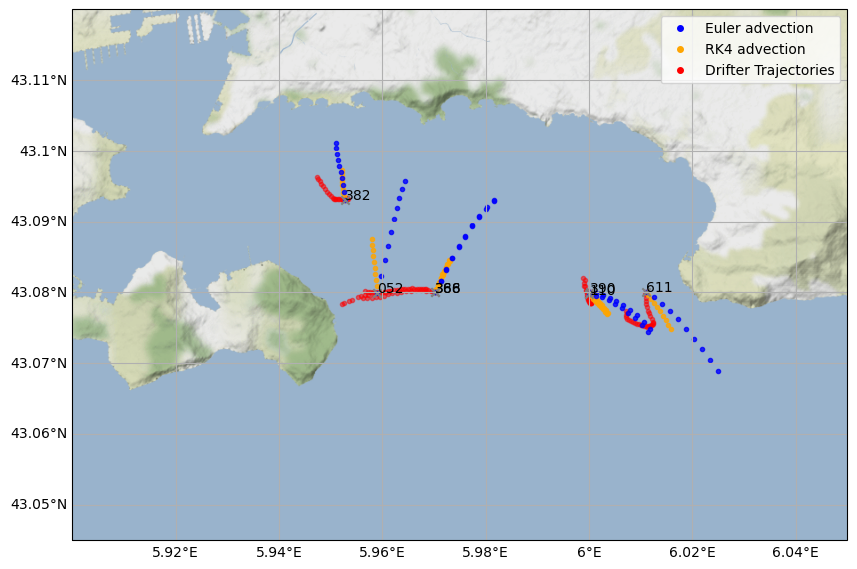

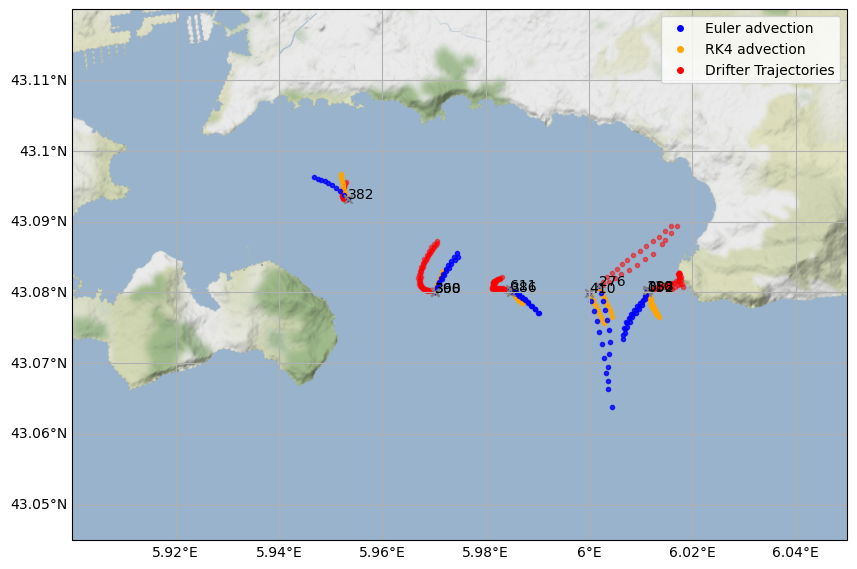

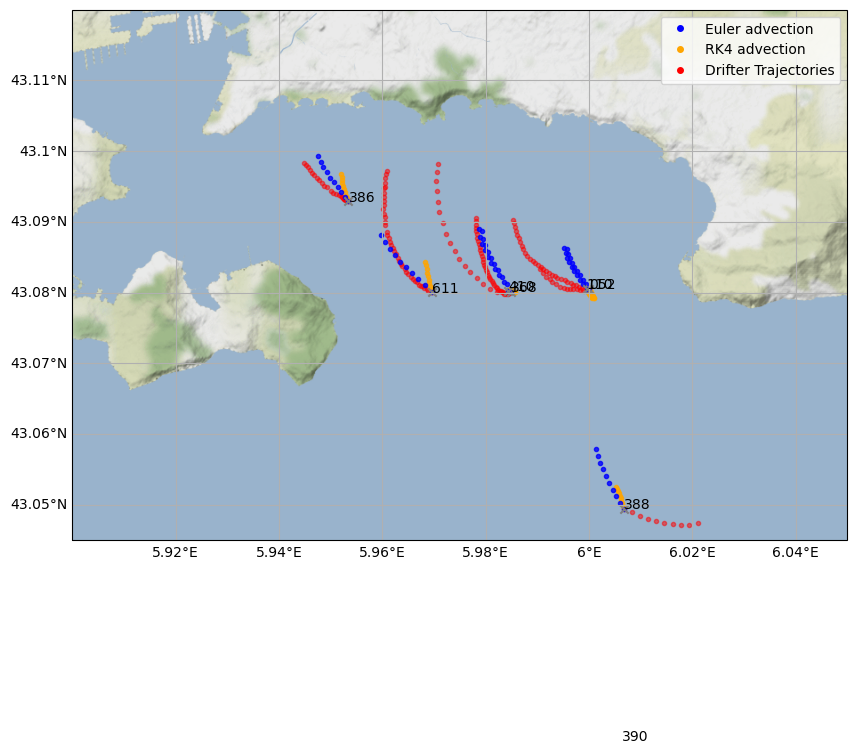

In [10]:
for key,data in advection_results.items():
    ax = plot_model_trajectories(data['euler'],data['RK4'],data['real'])
    #ax.set_title(key)

In [16]:
def velocity_error(data_drifter):
    lats = data_drifter['Latitude'].to_numpy()
    lons = data_drifter['Longitude'].to_numpy()
    time = data_drifter['Julian_date'].to_numpy()
    real_vels = data_drifter['velocity'].to_numpy()
    model_vels = []
    for lat,lon,t in zip(lats,lons,time):    
        model_vels.append(
            xrds['norm'].sel({"time":t,"lon":lon,"lat":lat,"depth":0},method='nearest').data
        )
    error = abs(real_vels[1:]-model_vels[1:])
    
    return error

vel_error_results = {}
for day,data_day in data_2021.items():
    vel_error_results[day] = {}
    for drifter,data_drifter in data_day['drifters'].items():
        if drifter!='410':#ugly outlayer...
            vel_error_results[day][drifter] = velocity_error(data_drifter)

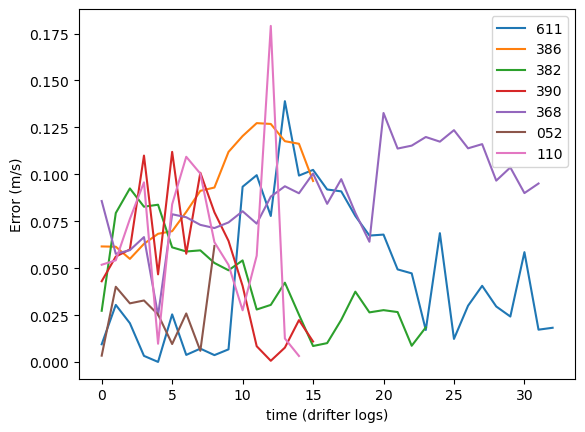

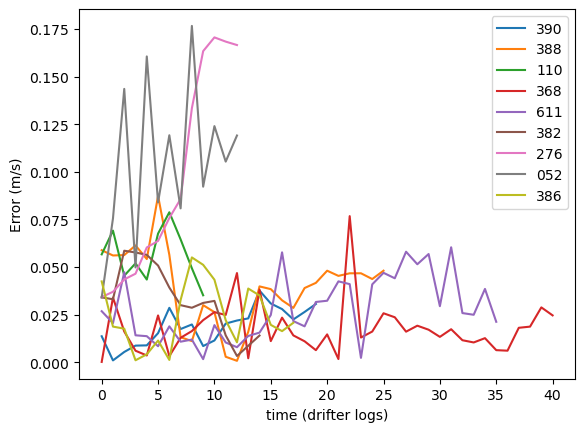

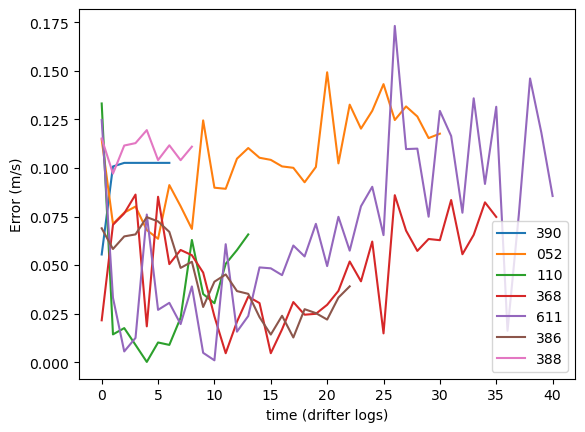

In [17]:
for day,values in vel_error_results.items():
    _, ax = plt.subplots()
    #ax.set_title(f"Velocities error {day}")
    ax.set_xlabel("time (drifter logs)")
    ax.set_ylabel("Error (m/s)")
    for drifter,error in values.items():
        ax.plot(error,label=drifter)
    ax.legend()